In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [56]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#function to convert the 5ratings classification problem to 3ratings classification problem
def convert_Sentiment(sentiment):
    if sentiment == "Extremely Positive" or sentiment == "Positive":
      return 2
    elif sentiment == "Extremely Negative" or sentiment == "Negative":
      return 0
    else:
      return 1

In [6]:
#read the training dataset and convert the labels
df_train = pd.read_csv("/content/gdrive/MyDrive/EDA/data/Corona_NLP_train.csv", encoding="latin_1")
df_train.Sentiment = df_train.Sentiment.apply(lambda x : convert_Sentiment(x))

In [7]:
#get the tweet text and the labels
X = df_train['OriginalTweet']
y = df_train['Sentiment']

In [10]:
#split the datasetset in: 90% train and 10% validation
X_train , X_val , y_train , y_val = train_test_split(X,y,test_size=0.1,random_state=0)

In [13]:
#printing sizes
print("The training X shape: {}".format(X_train.shape))
print("The validation X shape: {}".format(X_val.shape))
print("The training y shape: {}".format(y_train.shape))
print("The validation y shape: {}".format(y_val.shape))

The training X shape: (37041,)
The validation X shape: (4116,)
The training y shape: (37041,)
The validation y shape: (4116,)


In [42]:
class FeatureEng:
  # class used for feature engineering
  def __init__(self):
    #define tokenizer in order to split sentence into words
    self.ttoken = TweetTokenizer(strip_handles=True, reduce_len=True)
    #define lemmatizer
    self.lemmatizer=WordNetLemmatizer()
    #define set of stopwords
    self.STOP_WORDS = stopwords.words('english')
  
  #preprocess a single tweet
  def preprocess(self, tweet):
    #first, we lowercase the tweet
    tweet = tweet.lower()
    #then we remove all characters that are not alpha
    tweet = re.sub('[^a-zA-Z]'," ",tweet)
    #we tokenized the sentence
    words_tweet = self.ttoken.tokenize(tweet)
    words = []
    #remove words that are stop words
    for word in words_tweet:
      if word not in self.STOP_WORDS:
        words.append(word)
    
    #lemmatize the remained words
    prep_words = []
    for word in words:
      lem = self.lemmatizer.lemmatize(word)
      prep_words.append(lem)
    
    return " ".join(prep_words)
  
  #preprocess all the tweets from a dataset
  def preprocess_dataset(self, df):
    X_prep = []
    for line in df:
      prep_line = self.preprocess(line)
      X_prep.append(prep_line)
    return X_prep
  
  #use the count vectorizer that converts a collection of text documents to a sparse matrix of token counts
  def prep_count(self, df_train, df_test, max_features):
    cv = CountVectorizer(max_features=max_features)
    X_train_cnt = cv.fit_transform(df_train).toarray()
    X_val_cnt = cv.transform(df_test).toarray()
    return X_train_cnt, X_val_cnt

In [43]:
#define the feature eng class
fe = FeatureEng()
#preprocessing of the datasets
X_train_prep = fe.preprocess_dataset(X_train)
X_val_prep = fe.preprocess_dataset(X_val)
X_train_cnt, X_val_cnt = fe.prep_count(X_train_prep, X_val_prep, 200)

In [45]:
#define different combinations for the model
count_features = [100, 200, 400, 800]
number_estimators = [50, 100, 200]

for count_feature in count_features:
  #apply count vectorizer
  X_train_cnt, X_val_cnt = fe.prep_count(X_train_prep, X_val_prep, count_feature)

  for number_estimator in number_estimators:
    #define the model and training
    rnd_clf = RandomForestClassifier(n_estimators=number_estimator, random_state=42)
    rnd_clf.fit(X_train_cnt,y_train)
    y_train_pred = rnd_clf.predict(X_train_cnt)
    y_val_pred = rnd_clf.predict(X_val_cnt)
    
    training_score = accuracy_score(y_train_pred, y_train)
    validation_score = accuracy_score(y_val_pred, y_val)

    print("Count features: {}, Number estimators: {}, Train acc: {}, Val acc: {}".format(count_feature, number_estimator, training_score, validation_score))

Count features: 100, Number estimators: 50, Train acc: 0.9289706001457844, Val acc: 0.5573372206025268
Count features: 100, Number estimators: 100, Train acc: 0.9289975972570935, Val acc: 0.5536929057337221
Count features: 100, Number estimators: 200, Train acc: 0.9290245943684026, Val acc: 0.5551506316812439
Count features: 200, Number estimators: 50, Train acc: 0.9759185767122918, Val acc: 0.5996112730806609
Count features: 200, Number estimators: 100, Train acc: 0.975999568046219, Val acc: 0.6044703595724004
Count features: 200, Number estimators: 200, Train acc: 0.975999568046219, Val acc: 0.6051992225461613
Count features: 400, Number estimators: 50, Train acc: 0.9916308954941822, Val acc: 0.6474732750242954
Count features: 400, Number estimators: 100, Train acc: 0.9917658810507276, Val acc: 0.652332361516035
Count features: 400, Number estimators: 200, Train acc: 0.9917658810507276, Val acc: 0.6484450923226434
Count features: 800, Number estimators: 50, Train acc: 0.9975162657595

In [46]:
#read the training dataset and convert the labels
df_test = pd.read_csv("/content/gdrive/MyDrive/EDA/data/Corona_NLP_test.csv", encoding="latin_1")
df_test.Sentiment = df_test.Sentiment.apply(lambda x : convert_Sentiment(x))

In [47]:
#get the tweet text and the labels
X_test = df_test['OriginalTweet']
y_test = df_test['Sentiment']

In [49]:
#get features of test dataset
X_test_prep = fe.preprocess_dataset(X_test)

In [50]:
#prepare the model with the best params
X_train_cnt, X_test_cnt = fe.prep_count(X_train_prep, X_test_prep, 800)
clf = RandomForestClassifier(n_estimators=200,random_state=42)
clf.fit(X_train_cnt,y_train)
y_test_pred = clf.predict(X_test_cnt)

In [51]:
test_score = accuracy_score(y_test_pred, y_test)
print("Accuracy score for the test set: {}".format(test_score))

Accuracy score for the test set: 0.6661400737230121


In [53]:
#get the classification report which includes precision, recall and f1 score
cr = classification_report(y_test_pred, y_test)
print(cr)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1639
           1       0.52      0.55      0.53       579
           2       0.71      0.70      0.70      1580

    accuracy                           0.67      3798
   macro avg       0.64      0.64      0.64      3798
weighted avg       0.67      0.67      0.67      3798



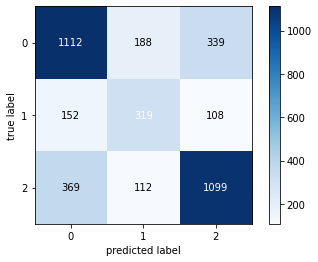

In [57]:
#plot the confusion matrix
confm = confusion_matrix(y_test_pred, y_test)

figure, ax = plot_confusion_matrix(conf_mat = confm,
                                   colorbar = True)
plt.show()
